# Improving energy estimation of a chemistry Hamiltonian with SQD

*Estimated QPU usage: 36 seconds (tested on IBM Sherbrooke)*

## Background

In this tutorial, we show how to post-process noisy quantum samples to find an approximation to the ground state of the nitrogen molecule $\text{N}_2$ at equilibrium bond length, using the [sample-based quantum diagonalization (SQD) algorithm](https://arxiv.org/abs/2405.05068), for samples taken from a 36-qubit quantum circuit (32 system qubits + 4 ancilla qubits). A Qiskit-based implementation is available as a [Qiskit Addons](https://github.com/Qiskit/qiskit-addon-sqd), more details can be found in the corresponding [docs](https://docs.quantum.ibm.com/guides/qiskit-addons-sqd) with a [simple example](https://docs.quantum.ibm.com/guides/qiskit-addons-sqd-get-started) to get started.
SQD is a technique for finding eigenvalues and eigenvectors of quantum operators, such as a quantum system Hamiltonian, using quantum and distributed classical computing together. Classical distributed computing is used to process samples obtained from a quantum processor, and to project and diagonalize a target Hamiltonian in a subspace spanned by them. This allows SQD to be robust to samples corrupted by quantum noise and deal with large Hamiltonians, such as chemistry Hamiltonians with millions of interaction terms, beyond the reach of any exact diagonalization methods. An SQD-based workflow has the following steps:

1. Choose a circuit ansatz and apply it on a quantum computer to a reference state (in this case, the [Hartree-Fock](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method) state).
2. Sample bitstrings from the resulting quantum state.
3. Run the *self-consistent configuration recovery* procedure on the bitstrings to obtain the approximation to the ground state.

### Quantum chemistry

The properties of molecules are largely determined by the structure of the electrons within them. As fermionic particles, electrons can be described using a mathematical formalism called second quantization. The idea is that there are a number of *orbitals*, each of which can be either empty or occupied by a fermion. A system of $N$ orbitals is described by a set of fermionic annihilation operators $\{\hat{a}_p\}_{p=1}^N$ that satisfy the fermionic anticommutation relations,

$$
\begin{align*}
\hat{a}_p \hat{a}_q + \hat{a}_q \hat{a}_p &= 0, \\
\hat{a}_p \hat{a}_q^\dagger + \hat{a}_q^\dagger \hat{a}_p &= \delta_{pq}.
\end{align*}
$$

The adjoint $\hat{a}_p^\dagger$ is called a creation operator.

So far, our exposition has not accounted for spin, which is a fundamental property of fermions. When accounting for spin, the orbitals come in pairs called *spatial orbitals*. Each spatial orbital is composed of two *spin orbitals*, one that is labeled "spin-$\alpha$" and one that is labeled "spin-$\beta$". We then write $\hat{a}_{p\sigma}$ for the annilation operator associated with the spin-orbital with spin $\sigma$ ($\sigma \in \{\alpha, \beta\}$) in spatial orbital $p$. If we take $N$ to be the number of spatial orbitals, then there are a total of $2N$ spin-orbitals. The Hilbert space of this system is spanned by $2^{2N}$ orthonormal basis vectors labeled with two-part bitstrings $\lvert z \rangle = \lvert z_\beta z_\alpha \rangle = \lvert z_{\beta, N} \cdots z_{\beta, 1} z_{\alpha, N} \cdots z_{\alpha, 1} \rangle$.

The Hamiltonian of a molecular system can be written as

$$
\hat{H} = \sum_{ \substack{pr\\\sigma} } h_{pr} \, \hat{a}^\dagger_{p\sigma} \hat{a}_{r\sigma}
+ \frac12
\sum_{ \substack{prqs\\\sigma\tau} }
h_{prqs} \, 
\hat{a}^\dagger_{p\sigma}
\hat{a}^\dagger_{q\tau}
\hat{a}_{s\tau}
\hat{a}_{r\sigma},
$$

where the $h_{pr}$ and $h_{prqs}$ are complex numbers called molecular integrals that can be calculated from the specification of the molecule using a computer program. In this tutorial, we compute the integrals using the [PySCF](https://pyscf.org/) software package.

For details about how the molecular Hamiltonian is derived, consult a textbook on quantum chemistry (for example, *Modern Quantum Chemistry* by Szabo and Ostlund). For a high-level explanation of how quantum chemistry problems are mapped onto quantum computers, check out the lecture [*Mapping Problems to Qubits*](https://youtu.be/TyFU6r8uEsE?t=900) from Qiskit Global Summer School 2024.

### Local unitary cluster Jastrow (LUCJ) ansatz

SQD requires a quantum circuit ansatz to draw samples from. In this tutorial, we'll use the [local unitary cluster Jastrow (LUCJ)](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k) ansatz due to its combination of physical motivation and hardware-friendliness.

The LUCJ ansatz is a specialized form of the general unitary cluster Jastrow (UCJ) ansatz, which has the form

$$
  \lvert \Psi \rangle = \prod_{\mu=1}^L e^{\hat{K}_\mu} e^{i \hat{J}_\mu} e^{-\hat{K}_\mu} | \Phi_0 \rangle
$$

where $\lvert \Phi_0 \rangle$ is a reference state, often taken to be the Hartree-Fock state, and the $\hat{K}_\mu$ and $\hat{J}_\mu$ have the form

$$
\hat{K}_\mu = \sum_{pq, \sigma} K_{pq}^\mu \, \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{q \sigma}
\;,\;
\hat{J}_\mu = \sum_{pq, \sigma\tau} J_{pq,\sigma\tau}^\mu \, \hat{n}_{p \sigma} \hat{n}_{q \tau}
\;,
$$

where we have defined the number operator

$$
\hat{n}_{p \sigma} = \hat{a}^\dagger_{p \sigma} \hat{a}^{\phantom{\dagger}}_{p \sigma}.
$$

The operator $e^{\hat{K}_\mu}$ is an orbital rotation, which can be implemented using known algorithms in linear depth and using linear connectivity.
Implementing the $e^{i \mathcal{J}_k}$ term of the UCJ ansatz requires either all-to-all connectivity or the use of a fermionic swap network, making it challenging for noisy pre-fault-tolerant quantum processors that have limited connectivity. The idea of the *local* UCJ ansatz is to impose sparsity constraints on the $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$ matrices which allow them to be implemented in constant depth on qubit topologies with limited connectivity. The constraints are specified by a list of indices indicating which matrix entries in the upper triangle are allowed to be nonzero (since the matrices are symmetric, only the upper triangle needs to be specified). These indices can be interpreted as pairs of orbitals that are allowed to interact.

As an example, consider a square lattice qubit topology. We can place the $\alpha$ and $\beta$ orbitals in parallel lines on the lattice, with connections between these lines forming "rungs" of a ladder shape, like this:

![square\_lattice\_gray\_150dpi.png](https://learning-api.quantum.ibm.com/assets/dcd54dc6-7b7c-481a-a950-abcaa95bbd08)

With this setup, orbitals with the same spin are connected with a line topology, while orbitals with different spins are connected when they share the same spatial orbital. This yields the following index constraints on the $\mathbf{J}$ matrices:

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, \ldots, N-1}
\end{align*}
$$

In other words, if the $\mathbf{J}$ matrices are nonzero only at the specified indices in the upper triangle, then the $e^{i \mathcal{J}_k}$ term can be implemented on a square topology without using any swap gates, in constant depth. Of course, imposing such constraints on the ansatz makes it less expressive, so more ansatz repetitions may be required.

The IBM hardware has a heavy-hex lattice qubit topology, in which case we can adopt a "zig-zag" pattern, depicted below. In this pattern, orbitals with the same spin are mapped to qubits with a line topology (red and blue circles), and a connection between orbitals of different spin is present at every 4th spatial orbital, with the connection being facilitated by an ancilla qubit (purple circles). In this case, the index constraints are

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, 4, 8, \ldots (p \leq N-1)}
\end{align*}
$$

![lucj\_ansatz\_zig\_zag\_pattern.jpg](https://learning-api.quantum.ibm.com/assets/fc816ba3-b050-4371-8b1c-43f30e626b50)

### Sample-based quantum diagonalization (SQD)

The self-consistent configuration recovery procedure is designed to extract as much signal as possible from noisy quantum samples. Because the molecular Hamiltonian conserves particle number and spin Z, it makes sense to choose a circuit ansatz that also conserves these symmetries. When applied to the Hartree-Fock state, the resulting state has a fixed particle number and spin Z in the noiseless setting. Therefore, the spin-$\alpha$ and spin-$\beta$ halves of any bitstring sampled from this state should have the same [Hamming weight](https://en.wikipedia.org/wiki/Hamming_weight) as in the Hartree-Fock state. Due to the presence of noise in current quantum processors, some measured bitstrings will violate this property. A simple form of postselection would discard these bitstrings, but this is wasteful because those bitstrings might still contain some signal. The self-consistent recovery procedure attempts to recover some of that signal in post-processing. The procedure is iterative and requires as input an estimate of the average occupancies of each orbital in the ground state, which is first computed from the raw samples. The procedure is run in a loop, and each iteration has the following steps:

1. For each bitstring that violates the specified symmetries, flip its bits with a probabilistic procedure designed to bring the bitstring closer to the current estimate of the average orbital occupancies, to obtain a new bitstring.
2. Collect all of the old and new bitstrings that satisfy the symmetries, and subsample subsets of a fixed size, chosen in advance.
3. For each subset of bitstrings, project the Hamiltonian into the subspace spanned by the corresponding basis vectors (see the [previous section](#quantum-chemistry) for a description of these basis vectors), and compute a ground state estimate of the projected Hamiltonian on a classical computer.
4. Update the estimate of the average orbital occupancies with the ground state estimate with the lowest energy.

The SQD workflow is depicted in the following diagram:

![sqd\_diagram.png](https://learning-api.quantum.ibm.com/assets/9bf3078e-757e-441e-9fcd-456ca8eddc80)

SQD is known to work well when the target eigenstate is sparse: the wave function is supported in a set of basis states $\mathcal{S} = \{|x\rangle \}$ whose size does not increase exponentially with the size of the problem.


## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.22 or later (`pip install qiskit-ibm-runtime`)
* Qiskit Addons SQD (`pip install qiskit-addon-sqd`)
* ffsim (`pip install ffsim`)


## Step 1: Map classical inputs to a quantum problem

In this tutorial, we will find an approximation to the ground state of the molecule at equilibrium in the 6-31G basis set. First, we specify the molecule and its properties.


In [1]:
import pyscf
import pyscf.cc
import pyscf.mcscf

# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="6-31g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Compute exact energy
exact_energy = cas.run().e_tot

converged SCF energy = -108.835236570775


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


CASCI E = -109.046671778080  E(CI) = -32.8155692383188  S^2 = 0.0000000


Before constructing the LUCJ ansatz circuit, we first perform a CCSD calculation in the following code cell. The [$t_1$ and $t_2$ amplitudes](https://en.wikipedia.org/wiki/Coupled_cluster#Cluster_operator) from this calculation will be used to initialize the parameters of the ansatz.


In [2]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.0398256929734  E_corr = -0.2045891221988317


<class 'pyscf.cc.ccsd.CCSD'> does not have attributes  converged


Now, we use [ffsim](https://github.com/qiskit-community/ffsim) to create the ansatz circuit. Since our molecule has a closed-shell Hartree-Fock state, we use the spin-balanced variant of the UCJ ansatz, [UCJOpSpinBalanced](https://qiskit-community.github.io/ffsim/api/ffsim.html#ffsim.UCJOpSpinBalanced). We pass interaction pairs appropriate for a heavy-hex lattice qubit topology (see the [background section on the LUCJ ansatz](#The-local-UCJ-\(LUCJ\)-ansatz)).


In [3]:
import ffsim
from qiskit import QuantumCircuit, QuantumRegister

n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]

ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

## Step 2: Optimize problem for quantum execution


Next, we optimize the circuit for a target hardware. We'll use the 127-qubit IBM Sherbrooke QPU.


In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.backend("ibm_strasbourg")

We recommend the following steps to optimize the ansatz and make it hardware-compatible.

* Select physical qubits (`initial_layout`) from the target hardware that adheres to the zig-zag pattern described above. Laying out qubits in this pattern leads to an efficient hardware-compatible circuit with less gates.
* Generate a staged pass manager using the [generate\_preset\_pass\_manager](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset#generate_preset_pass_manager) function from qiskit with your choice of `backend` and `initial_layout`.
* Set the `pre_init` stage of your staged pass manager to `ffsim.qiskit.PRE_INIT`. `ffsim.qiskit.PRE_INIT` includes qiskit transpiler passes that decompose gates into orbital rotations and then merges the orbital rotations, resulting in fewer gates in the final circuit.
* Run the pass manager on your circuit.


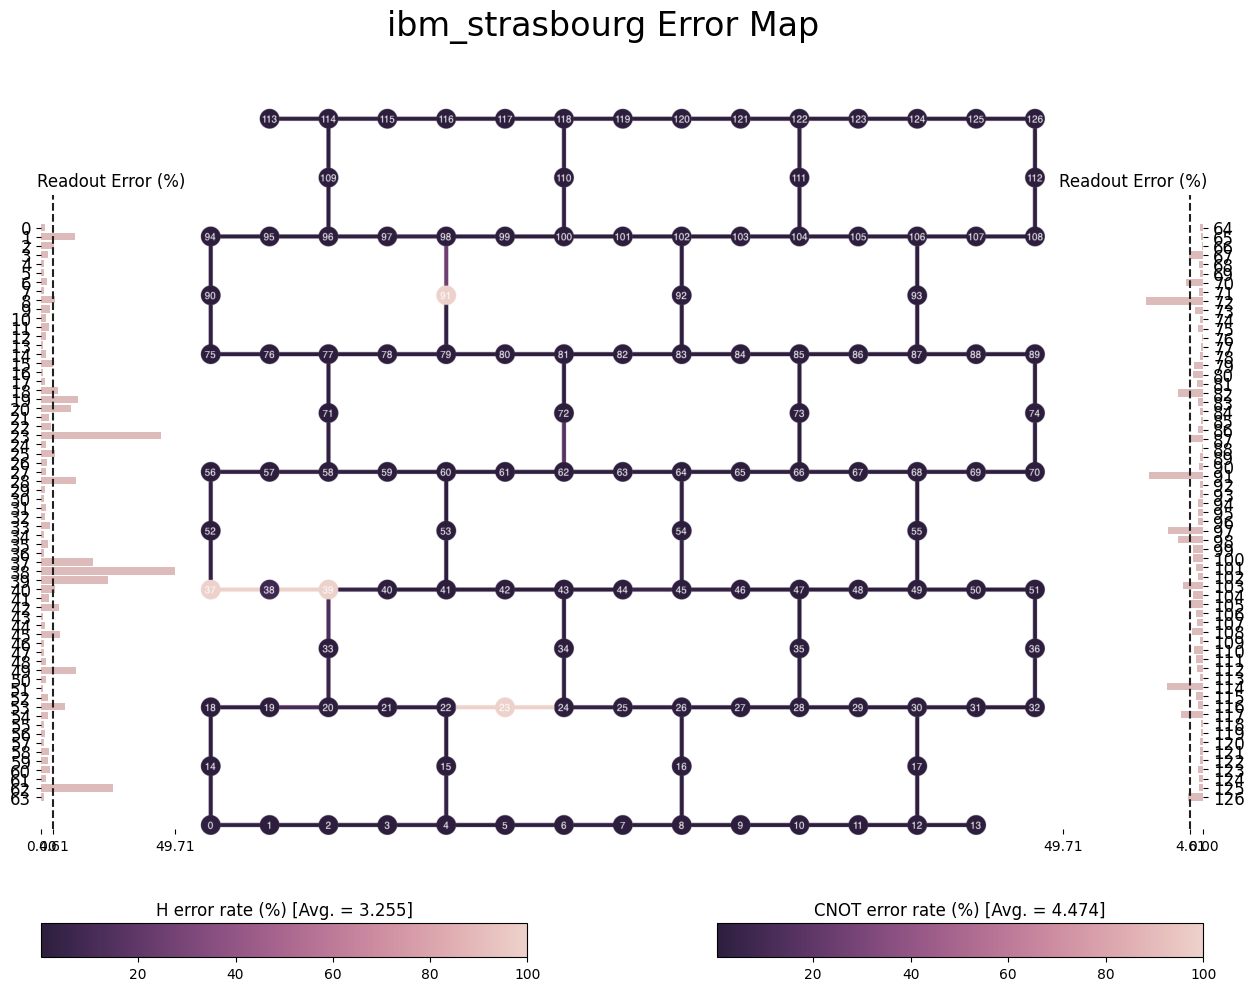

In [7]:
from qiskit.visualization import plot_error_map, plot_gate_map, plot_circuit_layout

plot_error_map(backend)

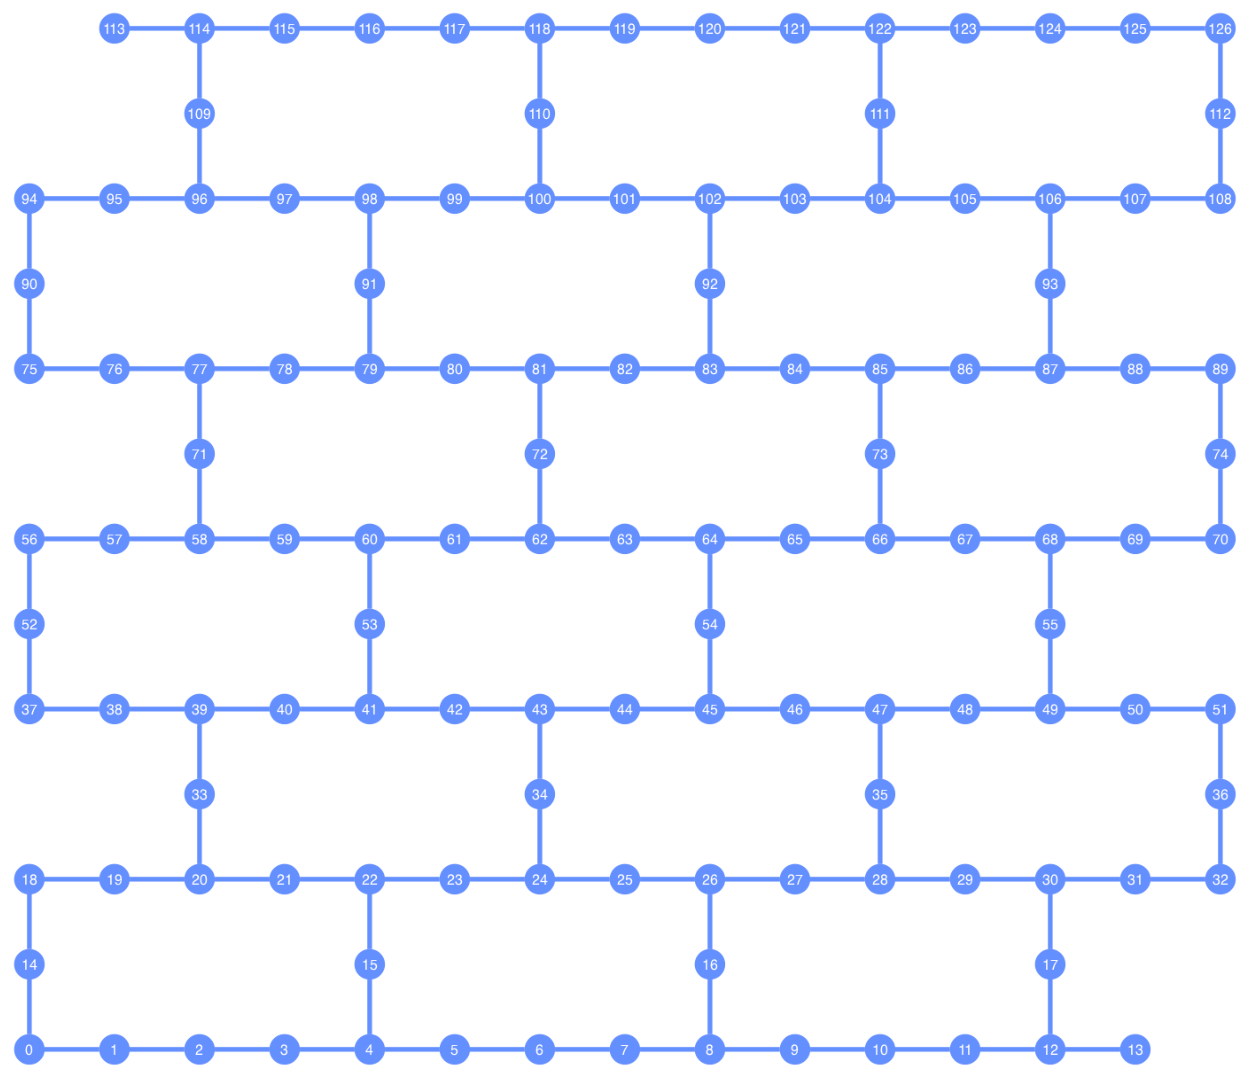

In [8]:
plot_gate_map(backend)

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

spin_a_layout = [12, 17, 30, 29, 28, 35, 47, 46, 45, 54, 64, 63, 62, 72, 81, 80]
spin_b_layout = [10, 9, 8, 16, 26, 25, 24, 34, 43, 42, 41, 53, 60, 59, 58, 71]
initial_layout = spin_a_layout + spin_b_layout

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict([('rz', 4287), ('sx', 3328), ('ecr', 1366), ('x', 265), ('measure', 32), ('barrier', 1)])
Gate counts (w/ pre-init passes): OrderedDict([('rz', 2407), ('sx', 2117), ('ecr', 730), ('x', 84), ('measure', 32), ('barrier', 1)])


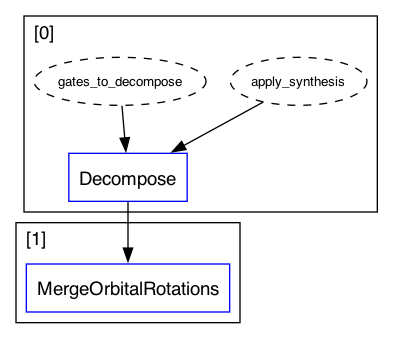

In [10]:
ffsim.qiskit.PRE_INIT.draw()

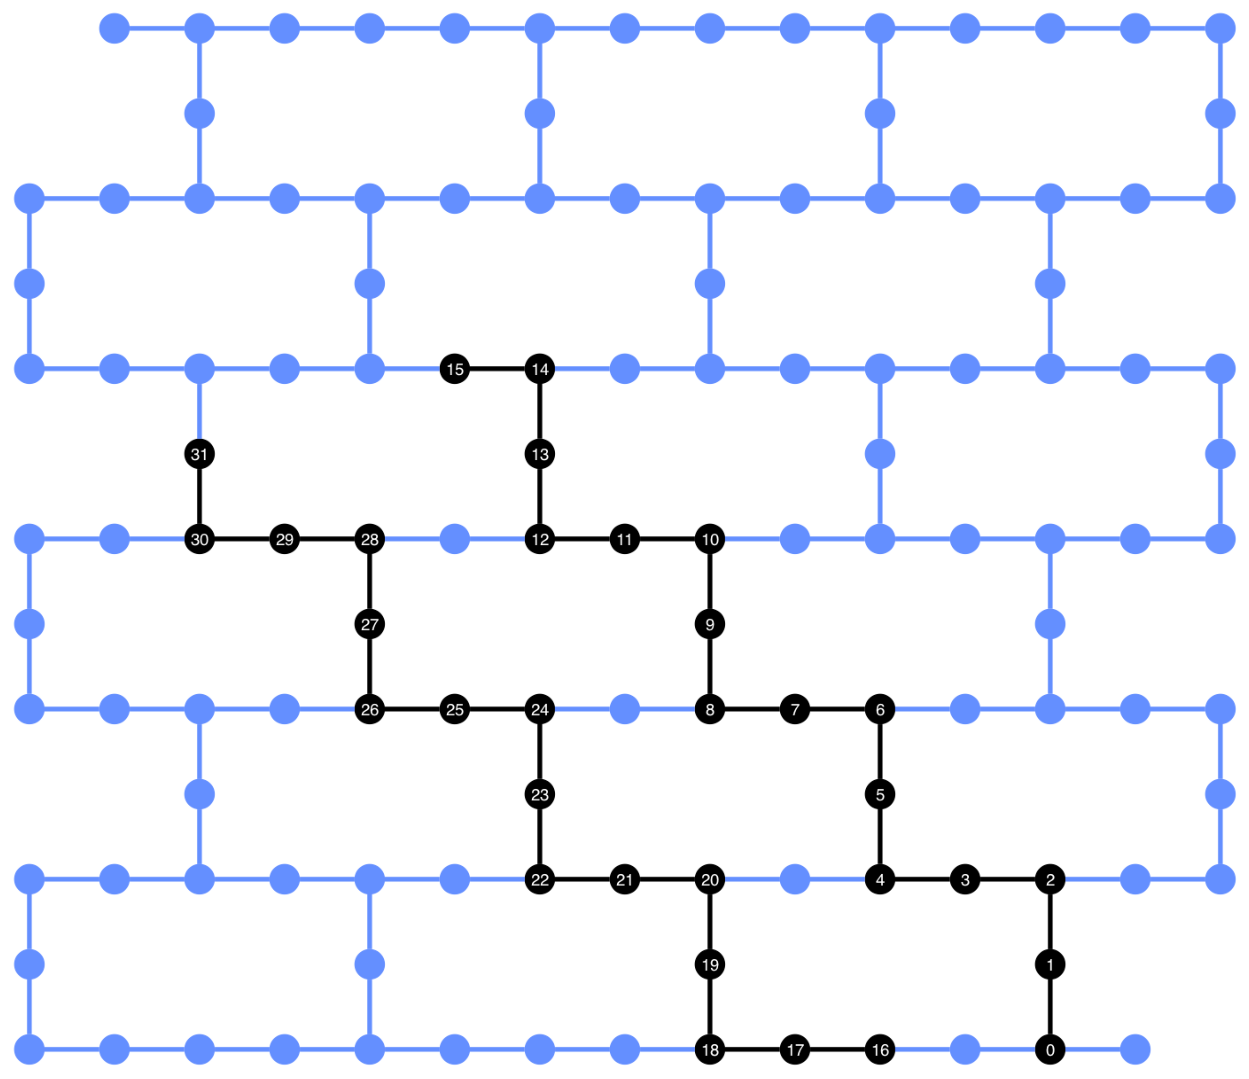

In [11]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(isa_circuit, backend)

## Step 3: Execute using Qiskit Primitives


After optimizing the circuit for hardware execution, we are ready to run it on the target hardware and collect samples for ground state energy estimation. As we only have one circuit, we will use Qiskit Runtime's [Job execution mode](https://docs.quantum.ibm.com/guides/execution-modes) and execute our circuit.


In [59]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=100_000)

In [13]:
primitive_result = job.result()
pub_result = primitive_result[0]
counts = pub_result.data.meas.get_counts()

In [ ]:
# pre-run counts
# counts = np.load("N2_device_counts.npy", allow_pickle=True).item()

## Step 4: Post-process and return result to desired classical format


SQD relies significantly on post-processing the bitstrings collected from the quantum computer. To prepare for post-processing, we will convert the counts dictionary to a bit array, which is an $M \times N$ matrix of zeros and ones, where $M$ is the number of shots and $N$ is the number of qubits.

Note that in Qiskit's bit ordering convention, bitstrings are indexed starting from the right. Therefore, the bit array holds the measurement results of the first qubit in the rightmost column (the column with index $N - 1$). Furthermore, the spin-$\alpha$ orbitals are indexed before the spin-$\beta$ orbitals, which means that the spin-$\alpha$ orbitals are to the right of the spin-$\beta$ orbitals.


In [14]:
from qiskit_addon_sqd.counts import counts_to_arrays

# Convert counts into bitstring and probability arrays
bitstring_matrix_full, probs_arr_full = counts_to_arrays(counts)

Recall that the self-consistent configuration recovery is an iterative procedure that runs in a loop. In the following code cell, the first iteration of the loop simply uses the raw samples (after postselection on symmetries) as input to the diagonalization procedure to obtain an estimate of the average orbital occupancies. Later iterations of the loop use these occupancies to generate new configurations from raw samples that violate the symmetries. These configurations are collected and then subsampled to produce batches of configurations, which are then used to project the Hamiltonian and compute a ground state estimate with an eigenstate solver.

There are a few user-controlled options which are important for this technique:

* `iterations`: Number of iterations of the self-consistent recovery loop.
* `n_batches`: Number of batches of configurations to subsample (this will be the number of separate calls to the eigenstate solver)
* `samples_per_batch`: Number of unique configurations to include in each batch
* `max_davidson_cycles`: Maximum number of Davidson cycles run by the eigenstate solver


In [23]:
from qiskit_addon_sqd.configuration_recovery import recover_configurations
from qiskit_addon_sqd.fermion import (
    bitstring_matrix_to_ci_strs,
    solve_fermion,
)
from qiskit_addon_sqd.subsampling import postselect_and_subsample

# SQD options
iterations = 5

# Eigenstate solver options
n_batches = 3
samples_per_batch = 5000
max_davidson_cycles = 200

# Self-consistent configuration recovery loop
e_hist = np.zeros((iterations, n_batches))  # energy history
s_hist = np.zeros((iterations, n_batches))  # spin history
occupancy_hist = []
avg_occupancy = None
for i in range(iterations):
    print(f"Starting configuration recovery iteration {i}")
    # On the first iteration, we have no orbital occupancy information from the
    # solver, so we begin with the full set of noisy configurations.
    if avg_occupancy is None:
        bs_mat_tmp = bitstring_matrix_full
        probs_arr_tmp = probs_arr_full

    # If we have average orbital occupancy information, we use it to refine the full set of noisy configurations
    else:
        bs_mat_tmp, probs_arr_tmp = recover_configurations(
            bitstring_matrix_full,
            probs_arr_full,
            avg_occupancy,
            num_elec_a,
            num_elec_b,
            rand_seed=rng,
        )

    # Create batches of subsamples. We post-select here to remove configurations
    # with incorrect hamming weight during iteration 0, since no config recovery was performed.
    batches = postselect_and_subsample(
        bs_mat_tmp,
        probs_arr_tmp,
        hamming_right=num_elec_a,
        hamming_left=num_elec_b,
        samples_per_batch=samples_per_batch,
        num_batches=n_batches,
        rand_seed=rng,
    )

    # Run eigenstate solvers in a loop. This loop should be parallelized for larger problems.
    e_tmp = np.zeros(n_batches)
    s_tmp = np.zeros(n_batches)
    occs_tmp = []
    coeffs = []
    for j in range(n_batches):
        strs_a, strs_b = bitstring_matrix_to_ci_strs(batches[j])
        print(f"Batch {j} subspace dimension: {len(strs_a) * len(strs_b)}")
        energy_sci, coeffs_sci, avg_occs, spin = solve_fermion(
            batches[j],
            hcore,
            eri,
            open_shell=open_shell,
            spin_sq=spin_sq,
            max_davidson=max_davidson_cycles,
        )
        energy_sci += nuclear_repulsion_energy
        e_tmp[j] = energy_sci
        s_tmp[j] = spin
        occs_tmp.append(avg_occs)
        coeffs.append(coeffs_sci)

    # Combine batch results
    avg_occupancy = tuple(np.mean(occs_tmp, axis=0))

    # Track optimization history
    e_hist[i, :] = e_tmp
    s_hist[i, :] = s_tmp
    occupancy_hist.append(avg_occupancy)

Starting configuration recovery iteration 0
Batch 0 subspace dimension: 418609
Batch 1 subspace dimension: 418609
Batch 2 subspace dimension: 418609
Starting configuration recovery iteration 1
Batch 0 subspace dimension: 9909904
Batch 1 subspace dimension: 10010896
Batch 2 subspace dimension: 9628609
Starting configuration recovery iteration 2
Batch 0 subspace dimension: 9765625
Batch 1 subspace dimension: 9253764
Batch 2 subspace dimension: 9455625
Starting configuration recovery iteration 3
Batch 0 subspace dimension: 9579025
Batch 1 subspace dimension: 9474084
Batch 2 subspace dimension: 9653449
Starting configuration recovery iteration 4
Batch 0 subspace dimension: 9535744
Batch 1 subspace dimension: 9734400
Batch 2 subspace dimension: 9455625


### Visualize the results

The first plot shows that after a couple of iterations we estimate the ground state energy within `~10 mH` (chemical accuracy is typically accepted to be `1 kcal/mol` $\approx$ `1.6 mH`). The energy can be improved by drawing more samples from the circuit or increasing the number of samples per batch.

The second plot shows the average occupancy of each spatial orbital after the final iteration. We can see that both the spin-up and spin-down electrons occupy the first five orbitals with high probability in our solutions.


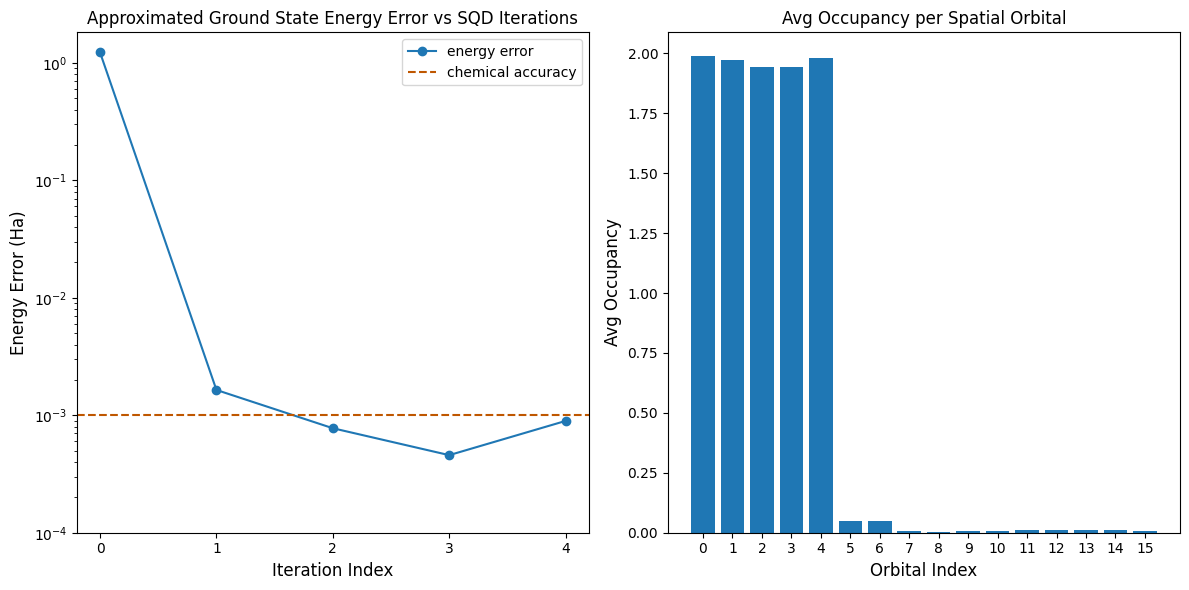

In [24]:
import matplotlib.pyplot as plt

# Data for energies plot
x1 = range(iterations)
e_diff = [abs(np.min(energies) - exact_energy) for energies in e_hist]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = occupancy_hist[-1][0] + occupancy_hist[-1][1]
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(y=chem_accuracy, color="#BF5700", linestyle="--", label="chemical accuracy")
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Tutorial Survey

<table style="width: 100%;">
<tbody>
<tr>
<td valign="top" style="width: 10%;"><img src="https://learning-api.quantum.ibm.com/assets/53171443-b07b-4ae6-a4be-9aec32a854f5" alt="Survey" width="100%" height="100%"></td>
<td valign="top"  style="width: 80%;"><strong><a title="Tutorial Survey" href="https://your.feedback.ibm.com/jfe/form/SV_8cECHVBBWBjt72S" target="_blank">Tutorial Survey</a></strong><p><p>Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.</td>
</tr>
</tbody>
</table>
